# Q1) Train a ResNet-18 classifier on CIFAR-100 using PyTorch.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR100, CIFAR10
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.models import resnet18
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.covariance import EmpiricalCovariance

## Transforms (including CIFAR100 Image Normalization and random horizontal flips)

In [2]:
# mean and std values for cifar100 image normalization
mean=[0.5071, 0.4867, 0.4408]
std=[0.2675, 0.2565, 0.2761]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

## Import data

In [3]:
# cifar100 training and testing data
train_ds = CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_ds = CIFAR100(root='./data', train=False, download=True, transform=test_transform)

c:\Users\yas1z\Downloads\OOD Assignment & Computer Vision TPS\.projvenv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [4]:
print(len(train_ds))
print(len(test_ds)) #50.000 training & 10.000 testing images 

50000
10000


## Intializing data loaders

In [5]:
# training and testing dataloaders
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=True)

## Visualizing sample image(s)

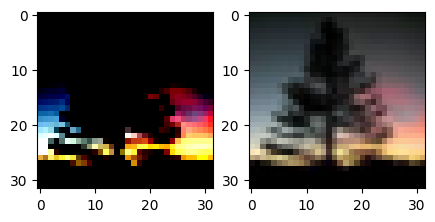

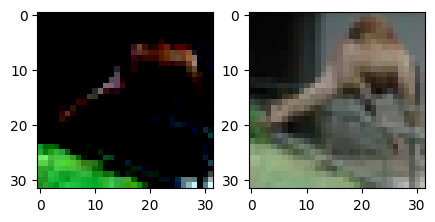

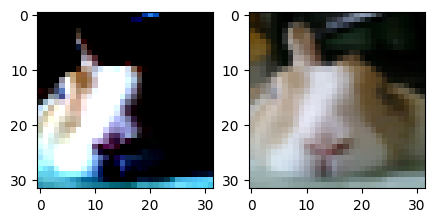

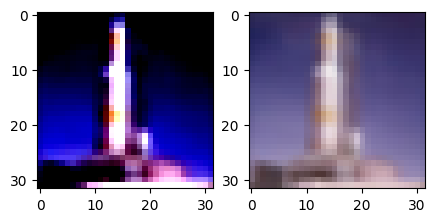

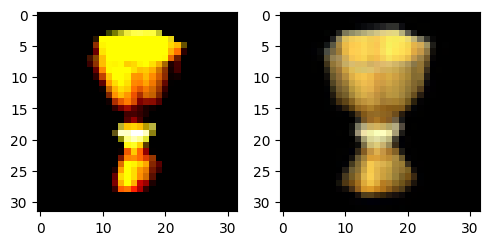

In [6]:
# One batch
images, labels = next(iter(train_loader))

# convert mean and std to tensors
tmean = torch.tensor(mean).view(3, 1, 1)
tstd = torch.tensor(std).view(3, 1, 1)

# denormalize normalized images for visualization purposes
denormalize = lambda img: img * tstd + tmean

for i in range(5):
    plt.figure(figsize=(5, 5))

    plt.subplot(121)
    img = images[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    plt.subplot(122)
    denormalized_img = denormalize(images[i]).permute(1, 2, 0).numpy()
    denormalized_img = np.clip(denormalized_img, 0, 1)
    plt.imshow(denormalized_img)

plt.tight_layout()
plt.show()

## Import ResNet-18

In [7]:
model = resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, out_features=100) # CIFAR100 has 100 classes, by default resnet18 uses 1000
model.to("cuda")
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## ResNet18 Training Loop

### Hyperparameters

In [8]:
lr = 1e-4
num_epochs = 60
step_size=30
gamma=0.1

In [9]:
# specify loss, optimizer and scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [10]:
train_losses, train_acc_list, test_acc_list, test_losses = [], [], [], []

# training/testing loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # inputs.size(0) == batch_size
        running_loss += loss.item() * inputs.size(0) # reduction='mean' by default, so we reconstruct the total_loss of a batch from the reduced one
        _, predicted = outputs.max(1) # returns max value, idx of max value's class, outputs.max(dim=1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_acc_list.append(train_acc)

    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = 100. * correct / total
    test_losses.append(test_loss)
    test_acc_list.append(test_acc)
    
    scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%')

Epoch [1/60] Train Loss: 3.0511 | Test Loss: 2.2148 | Train Acc: 28.14% | Test Acc: 42.16%
Epoch [2/60] Train Loss: 1.9310 | Test Loss: 1.8705 | Train Acc: 48.51% | Test Acc: 49.71%
Epoch [3/60] Train Loss: 1.5613 | Test Loss: 1.7377 | Train Acc: 56.93% | Test Acc: 53.16%
Epoch [4/60] Train Loss: 1.3126 | Test Loss: 1.6805 | Train Acc: 63.21% | Test Acc: 55.10%
Epoch [5/60] Train Loss: 1.1051 | Test Loss: 1.6566 | Train Acc: 68.59% | Test Acc: 55.97%
Epoch [6/60] Train Loss: 0.9428 | Test Loss: 1.6625 | Train Acc: 72.98% | Test Acc: 56.52%
Epoch [7/60] Train Loss: 0.7893 | Test Loss: 1.6873 | Train Acc: 77.20% | Test Acc: 56.41%
Epoch [8/60] Train Loss: 0.6603 | Test Loss: 1.7310 | Train Acc: 81.13% | Test Acc: 57.01%
Epoch [9/60] Train Loss: 0.5576 | Test Loss: 1.7674 | Train Acc: 83.85% | Test Acc: 57.29%
Epoch [10/60] Train Loss: 0.4658 | Test Loss: 1.8035 | Train Acc: 86.62% | Test Acc: 56.97%
Epoch [11/60] Train Loss: 0.3903 | Test Loss: 1.8619 | Train Acc: 88.79% | Test Acc: 57.2

### Visualize train and test curves

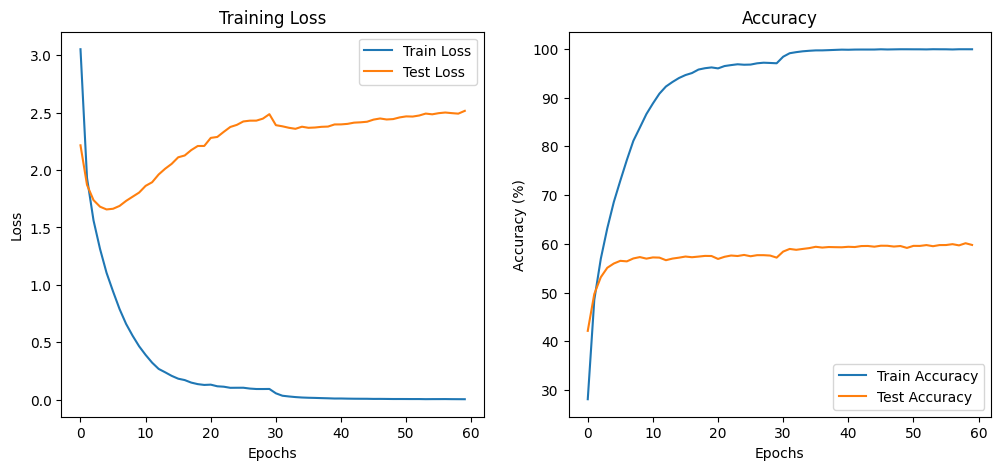

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

plt.show()

In [12]:
# save the model parameters after training if needed to reload
torch.save(model.state_dict(), "resnet18_cifar100.pth")

In [13]:
# model = resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
# model.fc = torch.nn.Linear(model.fc.in_features, out_features=100) # CIFAR100 has 100 classes, by default resnet18 uses 1000
# model.load_state_dict(torch.load("resnet18_cifar100.pth", weights_only=True))
# model.to("cuda")
# model.eval()

# Q2) Implement and compare the following OOD scores:
<ul style="font-size:1.5em;">
  <li>Max Softmax Probability (MSP)</li>
  <li>Maximum Logit Score</li>
  <li>Mahalanobis</li>
  <li>Energy Score</li>
  <li>ViM</li>
</ul>


## Max Softmax Probability (MSP), Maximum Logit Score (MLS) and Energy Score (ES) 

In [14]:
def compute_scores(loader):
    global model
    model.eval()

    msp_scores = [] # Maximum softmax probability scores
    mls_scores = [] # Maximum logits scores
    energy_scores = [] # Energy scores

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            logits = model(images)

            # MSP
            msp, _ = torch.max(torch.softmax(logits, dim=1), 1)
            msp_scores.append(msp.cpu()) # Debug CUDA out of memory

            # MLS
            mls, _ = torch.max(logits, dim=1)
            mls_scores.append(mls.cpu())

            # ES
            es = torch.logsumexp(logits, dim=1)
            energy_scores.append(es.cpu())

    return torch.cat(msp_scores), torch.cat(mls_scores), torch.cat(energy_scores)

## CIFAR10 (Near-OOD)

In [15]:
# loading the CIFAR10 dataset
ood_train = CIFAR10(root='./ood_data', train=True, download=True, transform=test_transform)
ood_test = CIFAR10(root='./ood_data', train=False, download=True, transform=test_transform)
ood_ds = ConcatDataset([ood_train, ood_test])

In [16]:
cifar10_loader = DataLoader(ood_ds, batch_size=128, shuffle=True)

In [17]:
# Test compute_scores function
msp_ood, mls_ood, es_ood = compute_scores(cifar10_loader)

print(f"msp_ood = {msp_ood[:5]}")
print(f"mls_ood = {mls_ood[:5]}")
print(f"es_ood = {es_ood[:5]}")

msp_ood = tensor([0.9997, 0.9969, 0.9985, 0.6437, 0.9851])
mls_ood = tensor([10.4287,  8.9939, 10.5890,  6.1331,  8.6619])
es_ood = tensor([10.4290,  8.9970, 10.5905,  6.5735,  8.6769])


In [18]:
# Compute ID scores using the cifar100 test loader
msp_id, mls_id, es_id = compute_scores(test_loader)

print(f"msp_id = {msp_id[:5]}")
print(f"mls_id = {mls_id[:5]}")
print(f"es_id = {es_id[:5]}")

msp_id = tensor([0.5361, 1.0000, 0.4065, 0.9990, 1.0000])
mls_id = tensor([ 3.0622, 15.4263,  4.0906, 13.1475, 18.6612])
es_id = tensor([ 3.6857, 15.4264,  4.9908, 13.1485, 18.6612])


In [19]:
def evaluate_ood(id_scores, ood_scores, name="MSP"):

    # Concatenate scores
    scores = torch.cat([id_scores, ood_scores]).cpu().numpy()

    # Labels: ID = 1, OOD = 0
    labels = np.concatenate([np.ones(len(id_scores)), np.zeros(len(ood_scores))])

    # AUROC
    auroc = roc_auc_score(labels, scores)

    # FPR95
    fpr, tpr, _ = roc_curve(labels, scores) # False positive rate, true positive rate
    
    # code to Visualize the ROC curve for each scoring method
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"AUROC={auroc:.4f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

    idx = np.where(tpr >= 0.95)[0][0]
    fpr95 = fpr[idx]

    return auroc * 100, fpr95 * 100

## Compute AUROC/FPR95% for these scores

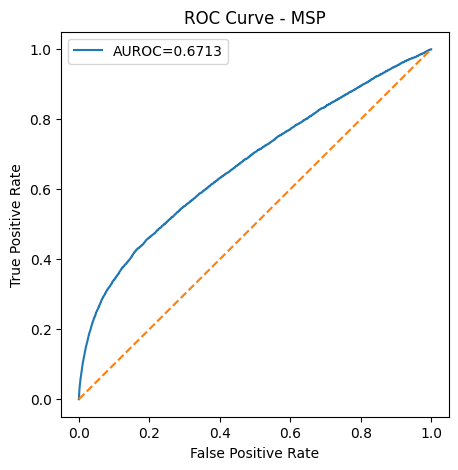

MSP OOD Detection:  (67.13069833333334, np.float64(89.58500000000001))


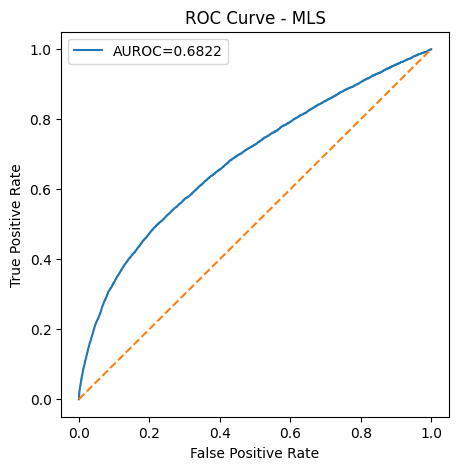

MLS OOD Detection:  (68.22473016666666, np.float64(88.64))


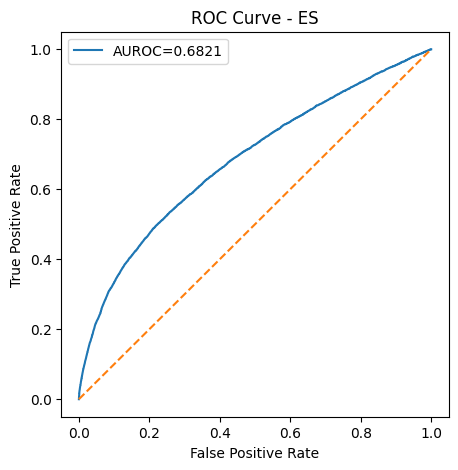

ES OOD Detection:  (68.20567633333334, np.float64(88.94333333333333))


In [20]:
print("MSP OOD Detection: ", evaluate_ood(msp_id, msp_ood, "MSP"))
print("MLS OOD Detection: ", evaluate_ood(mls_id, mls_ood, "MLS"))
print("ES OOD Detection: ", evaluate_ood(es_id, es_ood, "ES"))

In [21]:
# copy of the model that'll let us extract features for Mahanabolis
feature_model = copy.deepcopy(model)
feature_model.fc = torch.nn.Identity()
print(feature_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Extract features for Mahalanobis

In [22]:
# Note: Normalizing features doesn't seem to be included in the Mahalanobis SOTA implementations, but it seems to make results better.
# We suspect that it's probably in the other SOTA OOD detection methods, but it's worth being noted.
def compute_mahalanobis_stats(model, train_loader, num_classes):
    model.eval()
    
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to("cuda")
            features = model(images)
            # We can feature norm here: features = torch.nn.functional.normalize(features, dim=1)
            features_list.append(features.cpu())
            labels_list.append(labels)

    features = torch.cat(features_list)
    labels = torch.cat(labels_list)
    
    feature_dim = features.shape[1]
    
    centered = []
    class_means = torch.zeros(num_classes, feature_dim)
    for c in range(num_classes):
        class_features = features[labels == c]
        class_means[c] = class_features.mean(dim=0)
        centered.append(class_features - class_means[c])

    centered = torch.cat(centered)

    cov = EmpiricalCovariance(assume_centered=True)
    cov.fit(features)
    precision = torch.tensor(cov.precision_)

    return class_means, precision

def mahalanobis_scores(model, loader, class_means, precision):
    model.eval()

    scores_all = []

    class_means = class_means.to("cuda")
    precision = precision.to("cuda")

    with torch.no_grad():
        for images, _ in loader:
            images = images.to("cuda")
            features = model(images)
            # We can feature norm here: features = torch.nn.functional.normalize(features, dim=1)

            batch_scores = []

            for c in range(class_means.shape[0]):
                diff = features - class_means[c]
                score = torch.sum((diff @ precision) * diff, dim=1)
                batch_scores.append(score)

            batch_scores = torch.stack(batch_scores, dim=1)

            # take min over classes
            min_scores, _ = batch_scores.min(dim=1)
            min_scores = -min_scores
            scores_all.append(min_scores.cpu())

    return torch.cat(scores_all)

In [23]:
num_classes = 100
class_means, precision = compute_mahalanobis_stats(feature_model, train_loader, num_classes)

# print(class_means)
# print(precision)

In [24]:
mahalanobis_id = mahalanobis_scores(feature_model, test_loader, class_means, precision)
mahalanobis_ood = mahalanobis_scores(feature_model, cifar10_loader, class_means, precision)

print(mahalanobis_id)
print(mahalanobis_ood)

tensor([-494.5270, -446.8998, -302.8326,  ..., -199.1401, -424.8625,
        -370.6535])
tensor([-554.7433, -379.7302, -452.1880,  ..., -523.4095, -518.2327,
        -405.4988])


## AUROC/FPR95% for Mahalanobis

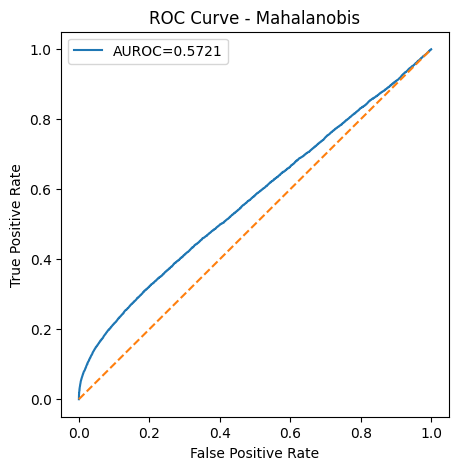

Mahalanobis OOD Detection: (57.21237708333333, np.float64(94.43166666666667))


In [25]:
print(f"Mahalanobis OOD Detection: {evaluate_ood(mahalanobis_id, mahalanobis_ood, "Mahalanobis")}")

## Extract stats for ViM

In [26]:
def compute_vim_stats(model, feature_model, trainloader,dim=300):
    model.eval()
    feature_model.eval()
    
    features_list = []
    labels_list = []
    W, b = model.fc.weight.data.cpu(), model.fc.bias.data.cpu() # Last layer of model

    with torch.no_grad():
        for images, labels in trainloader:
            images = images.to("cuda")
            features = feature_model(images)
            features_list.append(features.cpu())
            labels_list.append(labels)

    features = torch.cat(features_list)
    labels = torch.cat(labels_list)

    mean = features.mean(dim=0)
    centered = features - mean # len(features) * 512
    cov = EmpiricalCovariance(assume_centered=True)
    cov.fit(centered)
    eigvals, eigvecs = torch.linalg.eigh(torch.from_numpy(cov.covariance_).float())
    
    # Sort descending and calculate null space (residual space)
    sort_perm = torch.argsort(eigvals, descending=True)
    NullSpace = eigvecs[:, sort_perm[dim:]]
    
    # 5. Compute Alpha using Max Logit (instead of Energy)
    W, b = model.fc.weight.data.cpu(), model.fc.bias.data.cpu()
    
    with torch.no_grad():
        logits = features @ W.T + b
        # (len(centered) * 512) @ (512 * dim)
        residual = torch.norm(centered @ NullSpace, dim=-1) # centered = centered @ NS + centered @ U @ U.T (U = principal subspace)

        alpha = logits.max(dim=-1).values.mean() / residual.mean()

    return mean, NullSpace, alpha, W, b

def compute_vim_scores(model, W, b,  testloader, alpha, NullSpace, mean):
    model.eval() # feature_model
    W = W.to("cuda")
    b = b.to("cuda")

    features_list = []
    logits_list = []
    with torch.no_grad():
        for images, label in testloader:
            images = images.to("cuda")
            features = model(images)
            logits = features @ W.T + b

            features_list.append(features.cpu())
            logits_list.append(logits.cpu())

    features_list = torch.cat(features_list)
    logits_list = torch.cat(logits_list)

    centered = features_list - mean
    residual = alpha * torch.norm(centered @ NullSpace, dim=-1)
    energy_id_val = torch.logsumexp(logits_list, dim=-1)
    score_id = -residual + energy_id_val
    
    return score_id

In [27]:
# Compute stats for ViM
mean, NullSpace, alpha, W, b = compute_vim_stats(model, feature_model, train_loader)

## AUROC/FPR95% for ViM

In [28]:
# Compute ViM scores
vim_id = compute_vim_scores(feature_model, W, b, test_loader, alpha, NullSpace, mean)
vim_ood = compute_vim_scores(feature_model, W, b, cifar10_loader, alpha, NullSpace, mean)

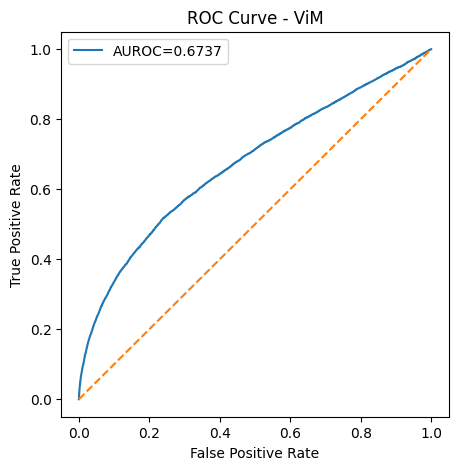

ViM OOD Detection: (67.3676615, np.float64(91.14166666666667))


In [29]:
print(f"ViM OOD Detection: {evaluate_ood(vim_id, vim_ood, "ViM")}")

# Q3-Q4) NC1-NC5

In [31]:
def compute_NC_stats(feature_model, trainloader):
    feature_model.eval()
    
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in trainloader:
            images = images.to("cuda")
            features = feature_model(images)
            features_list.append(features.cpu())
            labels_list.append(labels)

    features = torch.cat(features_list)
    labels = torch.cat(labels_list)
    
    feature_dim = features.shape[1]
    
    class_means = torch.zeros(num_classes, feature_dim)
    for c in range(num_classes):
        class_features = features[labels == c]
        class_means[c] = class_features.mean(dim=0)
    
    return features, labels, class_means

In [32]:
features_list, labels_list, class_means = compute_NC_stats(feature_model, train_loader)

### NC1

In [33]:
def compute_NC1(features, labels, class_means):
    C = 100 # CIFAR100
    mu_G = class_means.mean(dim=0, keepdim=True) # Global mean
    N = features.shape[0] # Total number of samples

    # Within-class covariance
    Sw = 0
    for c in range(C):
        h_c = features[labels == c]
        z = h_c - class_means[c]
        Sw += torch.matmul(z.T, z)
    Sw /= N

    # Between-class covariance
    M_centered = class_means - mu_G # Centered class means
    Sb = torch.matmul(M_centered.T, M_centered) / C
    inv_Sb = torch.linalg.pinv(Sb, hermitian=True) # Hermitian=True => torch.linalg.eigh()

    NC1 = torch.trace(Sw @ inv_Sb) / C
    return NC1.item()

In [34]:
print(compute_NC1(features_list, labels_list, class_means))

1.1276637315750122


### NC2

In [35]:
# mutual coherenceood_n_classes
def coherence(V, C=100):
    G = V @ V.T
    G += torch.ones((C, C)) / (C-1) # theta_ij converges to -1/(C-1) => add 1/(C-1) to make it converge to 0
    G -= torch.diag(torch.diag(G))
    res = torch.norm(G, 1).item() / (C*(C-1))
    return res

In [36]:
def compute_NC2(class_means):
    C = class_means.shape[0] # 100
    M = class_means - class_means.mean(dim=0, keepdim=True)

    M_norm = M / torch.norm(M, dim=1, keepdim=True) # Normalized means matrix (M)
    nc2 = coherence(M_norm, C)
    return nc2

In [37]:
print(compute_NC2(class_means)) # 1/(C-1) = 1/99 ~= 0.0101...

0.07216320307567867


### NC3

In [38]:
def compute_NC3(W, class_means):
    W_norm = W / torch.norm(W, dim=1, keepdim=True)
    M = class_means - class_means.mean(dim=0, keepdim=True) # Mean_class - Global mean
    M_norm = M / torch.norm(M, dim=1, keepdim=True)

    nc3 = torch.norm(W_norm - M_norm).item()
    return nc3

In [39]:
print(compute_NC3(model.fc.weight.data.cpu(), class_means))

6.060451507568359


### NC4

In [40]:
def compute_NC4(features, W, b, class_means):
    # Simplification of network to a NCC (nearest class-center classification)
    # Models simplifies to an euclidian distance between class centers
    logits = features @ W.T + b # classification layer
    net_pred = logits.argmax(dim=1)

    dists = torch.cdist(features, class_means) # euclidian distance between features and class means
    ncc_pred = dists.argmin(dim=1) # nearest class-center classification model prediction

    mismatch = (net_pred != ncc_pred).float().mean() # comparison between predictions
    return mismatch.item()

In [41]:
compute_NC4(features_list, model.fc.weight.data.cpu(), model.fc.bias.data.cpu(), class_means)

0.00019999999494757503

### NC5

In [42]:
def compute_NC5(class_means, ood_mean):
    # <mu_normalized, ood_normalized> = cos(angle between them). If cos == 0 => orthogonal
    ood_norm = torch.norm(ood_mean)

    cosines = []
    for c in range(class_means.shape[0]):
        mu = class_means[c]
        cos = torch.abs(torch.dot(mu, ood_mean) /
                        (torch.norm(mu) * ood_norm))
        cosines.append(cos)

    return torch.mean(torch.stack(cosines)).item()

In [43]:
# ood_mean computing
features_ood_list = []
with torch.no_grad():
    for images, _ in cifar10_loader:
        images = images.to("cuda")
        features_ood = feature_model(images)
        features_ood_list.append(features_ood.cpu())
features_ood = torch.cat(features_ood_list)
ood_mean = features_ood.mean(dim=0)
# print(ood_mean)
# print(ood_mean.shape)

In [44]:
print(compute_NC5(class_means, ood_mean))

0.7210302948951721
